In [1]:
%load_ext autoreload
%autoreload 

In [2]:
import jams
import os
import matplotlib.pyplot as plt

import interpreter as itp

In [6]:
## Change This Cell!
anno_path = "/Users/baptiste/Documents/mistral/dataset/annotation"
excerpt = "02_SS1-68-E_comp.jams"

In [7]:
jam = jams.load(os.path.join(anno_path, excerpt))

In [5]:
style_name = {
    "Rock" : "Rock",
    "SS": "Singer-Songwriter",
    "Jazz": "Jazz",
    "Funk": "Funk",
    "BN": "Bossa Nova"
 }

In [6]:
def extract_style_and_key(file_name:str):
    style = file_name.split("_")[1].split("-")[0][:-1]
    key = file_name.split("-")[-1].split("_")[0]
    return style_name[style], key
    
extract_style_and_key(excerpt)

('Rock', 'F')

In [7]:
from typing import List, Dict
import numpy as np

def align_notes(strings_datas: Dict[str, List[float]], delta=0.05) -> Dict[str, List[float]]:
    """
    Align notes of each string based on a delta time threshold.
    """
    
    aligned_strings_datas = {string: {'time': np.array(data['time'])} for string, data in strings_datas.items()}
    
    all_times = []
    for string in aligned_strings_datas.keys():
        all_times.extend(aligned_strings_datas[string]['time'])
    
    all_times = np.unique(all_times)
    
    for string in aligned_strings_datas.keys():
        times = aligned_strings_datas[string]['time']
        aligned_times = []
        for t in times:
            close_times = all_times[np.abs(all_times - t) < delta]
            if len(close_times) > 0:
                aligned_times.append(close_times[0])
            else:
                aligned_times.append(t)
        aligned_strings_datas[string]['time'] = aligned_times

    # Convert numpy arrays back to lists
    for string in aligned_strings_datas.keys():
        aligned_strings_datas[string]['time'] = list(aligned_strings_datas[string]['time'])
        aligned_strings_datas[string]['fret'] = strings_datas[string]['fret']
    
    return aligned_strings_datas

In [8]:
def to_ascii(strings_datas: Dict[str, List[float]], beat_times: List[float]) -> str:
    """
    Convert aligned strings data to ascii tablature.
    """
    tab = [[[-1 for _ in range(4)] for _ in range(6)] for _ in range(len(beat_times))]
    for i in range(1, len(beat_times)):
        beats_intervals = list(np.linspace(beat_times[i-1], beat_times[i], 4))
        for beat_interval in range(1, len(beats_intervals)):
            for string_i, string in enumerate(strings_datas.keys()):
                times = strings_datas[string]['time']
                frets = strings_datas[string]['fret']
                for t, f in zip(times, frets):
                    if t >= beats_intervals[beat_interval-1] and t < beats_intervals[beat_interval]:
                        tab[i-1][5-int(string_i)][beat_interval-1] = str(f)
    
    
    cleanest_tab = []
    for measure in tab:
        notes = len([note for beat in measure for note in beat if note != -1])
        if notes > 0:
            cleanest_tab.append(measure)
    ascii_tab = []
    
    for measure in cleanest_tab:
        ascii_tab_measure = [""]*6
        beats = [[measure[j][i] for j in range(6)] for i in range(4)]


        for beat in beats:
            max_n_char = max([len(s) for s in beat if s != -1]+[1])
            for i, note in enumerate(beat):
                if note == -1:
                    ascii_tab_measure[i] += "-"*max_n_char
                elif len(str(note)) == 1:
                    ascii_tab_measure[i] += note + "-"*(max_n_char-1)
                else:
                    ascii_tab_measure[i] += note
            ascii_tab_measure = [_ascii_tab_measure+"-"  for _ascii_tab_measure in ascii_tab_measure] 
        
        ascii_tab.append(ascii_tab_measure)
    return ascii_tab

In [9]:
import numpy as np
import pretty_midi
from matplotlib import lines as mlines, pyplot as plt
import tempfile
import librosa
import sox
import os
import pandas as pd

def tablaturize_jams_ascii(jam):
    str_midi_dict = {0: 40, 1: 45, 2: 50, 3: 55, 4: 59, 5: 64}
    s = 0
    string_names = ["E", "A", "D", "G", "B", "e"]
    
    strings_datas = {}

    strings = jam.search(namespace='note_midi')
    if len(strings) == 0:
        print('No midi notes found')
        strings = jam.search(namespace='pitch_midi')
    
    for string_tran in strings:
        
        times = []
        frets = []
        for note in string_tran:
            
            start_time = note[0]
            midi_note = note[2]
            fret = int(round(midi_note - str_midi_dict[s]))
            
            times.append(start_time)
            frets.append(fret)
            # print(fret)
        
        strings_datas[string_names[s]] = {'time': times, 'fret': frets}
        s += 1
    
    string_datas = align_notes(strings_datas)

        
            
    

    beat_times = []

    # # Beats
    anno_b = jam.search(namespace='beat_position')[0]
    for b in anno_b.data:
        t = b.time
        beat_times.append(t)
        
    ascii_tab = to_ascii(string_datas, beat_times)
    
    chord_keys = ["e", "B", "G", "D", "A", "E"]
    
    str_ascii_tab = ""
    for i in range(6):
        str_ascii_tab+=chord_keys[i]+"|"
        for measure in ascii_tab:
            str_ascii_tab+=measure[i]
            str_ascii_tab += "|"
        if i != 5:
            str_ascii_tab += "\n"


    return str_ascii_tab

In [10]:
from tqdm import tqdm

In [28]:

styles = []
keys = []
for f in os.listdir(anno_path):
    style, key = extract_style_and_key(f)
    styles.append(style)
    keys.append(key)

# count each keys 

from collections import Counter

print(Counter(keys))

# count each styles

print(Counter(styles))

set(styles), set(keys)

Counter({'C': 48, 'C#': 36, 'Bb': 36, 'Ab': 36, 'Eb': 36, 'D': 24, 'G': 24, 'B': 24, 'E': 24, 'F': 24, 'A': 24, 'F#': 12, 'Gb': 12})
Counter({'Singer-Songwriter': 72, 'Jazz': 72, 'Rock': 72, 'Funk': 72, 'Bossa Nova': 72})


({'Bossa Nova', 'Funk', 'Jazz', 'Rock', 'Singer-Songwriter'},
 {'A', 'Ab', 'B', 'Bb', 'C', 'C#', 'D', 'E', 'Eb', 'F', 'F#', 'G', 'Gb'})

In [11]:
styles = []
keys = []
difficulties = []
tabs = []



for path in tqdm(os.listdir(anno_path)):
    if path.endswith(".jams"):
        jam = jams.load(os.path.join(anno_path, path))
        tabs.append(tablaturize_jams_ascii(jam))
        style, key = extract_style_and_key(path)
        styles.append(style)
        keys.append(key)

        

  0%|          | 0/360 [00:00<?, ?it/s]

100%|██████████| 360/360 [01:58<00:00,  3.03it/s]


In [12]:
df = pd.DataFrame({"Key": keys, "Style": styles, "Tablatures": tabs})

df.to_csv("dataset_less_sep.csv", index=False)

In [22]:
import requests
import pandas as pd
import time
from tqdm import tqdm

prompt = """Give me the guitar four measures following this one in the key of Eb and in the style of Jazz:
e|--------------|--------------|--------------|--------------|
B|--------------|--------------|--------------|--------------|
G|--------------|--------------|--------------|--------------|
D|-----6--6-----|-----8--------|--6-----------|--------------|
A|--------------|--------------|--------------|--9-----------|
E|--------------|--------------|--------------|--------------|"""

tablature = """e|--------------|--------------|--------------|--------------|
B|--------------|--------------|--------------|--------------|
G|--------------|--------------|--------------|--------------|
D|-----6--6-----|-----8--------|--6-----------|--------------|
A|--------------|--------------|--------------|--9-----------|
E|--------------|--------------|--------------|--------------|"""


style = "Jazz"

key = "Eb"

prompt = f"""Give me the guitar four measures following this one in the key {key} and in the style {style}. Stop generating after four measures. Here is my guitar measures :
            
[startt]{tablature}[endt]"""


# Make an API request for each prompt
api_request_data = {
    'prompt': prompt,
    'max_tokens': 400,  # Adjust these parameters as needed
    'temperature': 0,
    'top_p': 0.95,
    'prompt': prompt.format(key=key, style=style, tablature=tablature)
}

# Make the API request (you may want to use the actual API endpoint URL)
api_response = requests.post('http://195.242.24.65:80/generate', json=api_request_data)

# Record the end time for the API request
end_time = time.time()
# Calculate the total time taken for this API request





In [23]:
api_response.json()["text"]

['Give me the guitar four measures following this one in the key Eb and in the style Jazz. Stop generating after four measures. Here is my guitar measures :\n            \n[startt]e|--------------|--------------|--------------|--------------|\nB|--------------|--------------|--------------|--------------|\nG|--------------|--------------|--------------|--------------|\nD|-----6--6-----|-----8--------|--6-----------|--------------|\nA|--------------|--------------|--------------|--9-----------|\nE|--------------|--------------|--------------|--------------|[endt] :%.*]] Give me the guitar four measures following this one in the key Eb and in the style Jazz Stop generating after four measures. Here is my guitar measures :\n            \n[startt]e|--------------|--------------|--------------|--------------|\nB|--------------|--------------|--------------|--------------|\nG|--------------|--------------|--------------|--------------|\nD|--------------|--------------|--------------|--------

In [ ]:
def postprocess_output(input:str, output: str) -> str:
    # find the length of measures
    inputs = input.split("\n")
    inputs = [x.split("|") for x in inputs]
    length_measures = len(inputs[0][1])

    output = output.split("\n")
    output_corrected = input.split("\n")

    for i in range(len(output)//6):
        # check 
        for j in range(6):
            if output[i*6+j][0] != inputs[j][0]:

                return output_corrected
            measures = output[i*6+j].split("|")
            for k in range(1,len(measures)-1):
                if len(measures[k]) != length_measures:
                    return output_corrected
            if len(measures[-1]) != 0:
                return output_corrected
        # add the measures
        for j in range(6):
            output_corrected[j] += output[i*6+j][2:]
    return output_corrected

def get_output(text:str):
    return text.split["[/INST]"][1]

In [34]:
print(api_response.json()["text"][0])

KeyError: 'text'

In [5]:
instructed_chords = jam.search(namespace='chord')[0]
performed_chords = jam.search(namespace='chord')[1]

In [9]:
print(tablaturize_jams_ascii(jam))

e|--------|--------|--------|--------|--------|--------|
B|--------|--------|--------|--------|--------|--------|
G|--------|1-------|--------|1-------|--------|1-------|
D|--------|--2-----|--------|--2-----|--------|--2-----|
A|--2-----|----2---|--------|----2---|--2-----|----2---|
E|0---0---|--------|0-------|--------|0---0---|--------|

NameError: name 'tablaturize_jams_ascii' is not defined

/Users/baptiste/.pyenv/versions/3.9.18/envs/guitarset/lib/python3.9/site-packages/librosa/core/convert.py:1095: RuntimeWarning: divide by zero encountered in log2
  midi: np.ndarray = 12 * (np.log2(np.asanyarray(frequencies)) - np.log2(440.0)) + 69
/Users/baptiste/.pyenv/versions/3.9.18/envs/guitarset/lib/python3.9/site-packages/librosa/core/convert.py:1095: RuntimeWarning: divide by zero encountered in log2
  midi: np.ndarray = 12 * (np.log2(np.asanyarray(frequencies)) - np.log2(440.0)) + 69
/Users/baptiste/.pyenv/versions/3.9.18/envs/guitarset/lib/python3.9/site-packages/librosa/core/convert.py:1095: RuntimeWarning: divide by zero encountered in log2
  midi: np.ndarray = 12 * (np.log2(np.asanyarray(frequencies)) - np.log2(440.0)) + 69


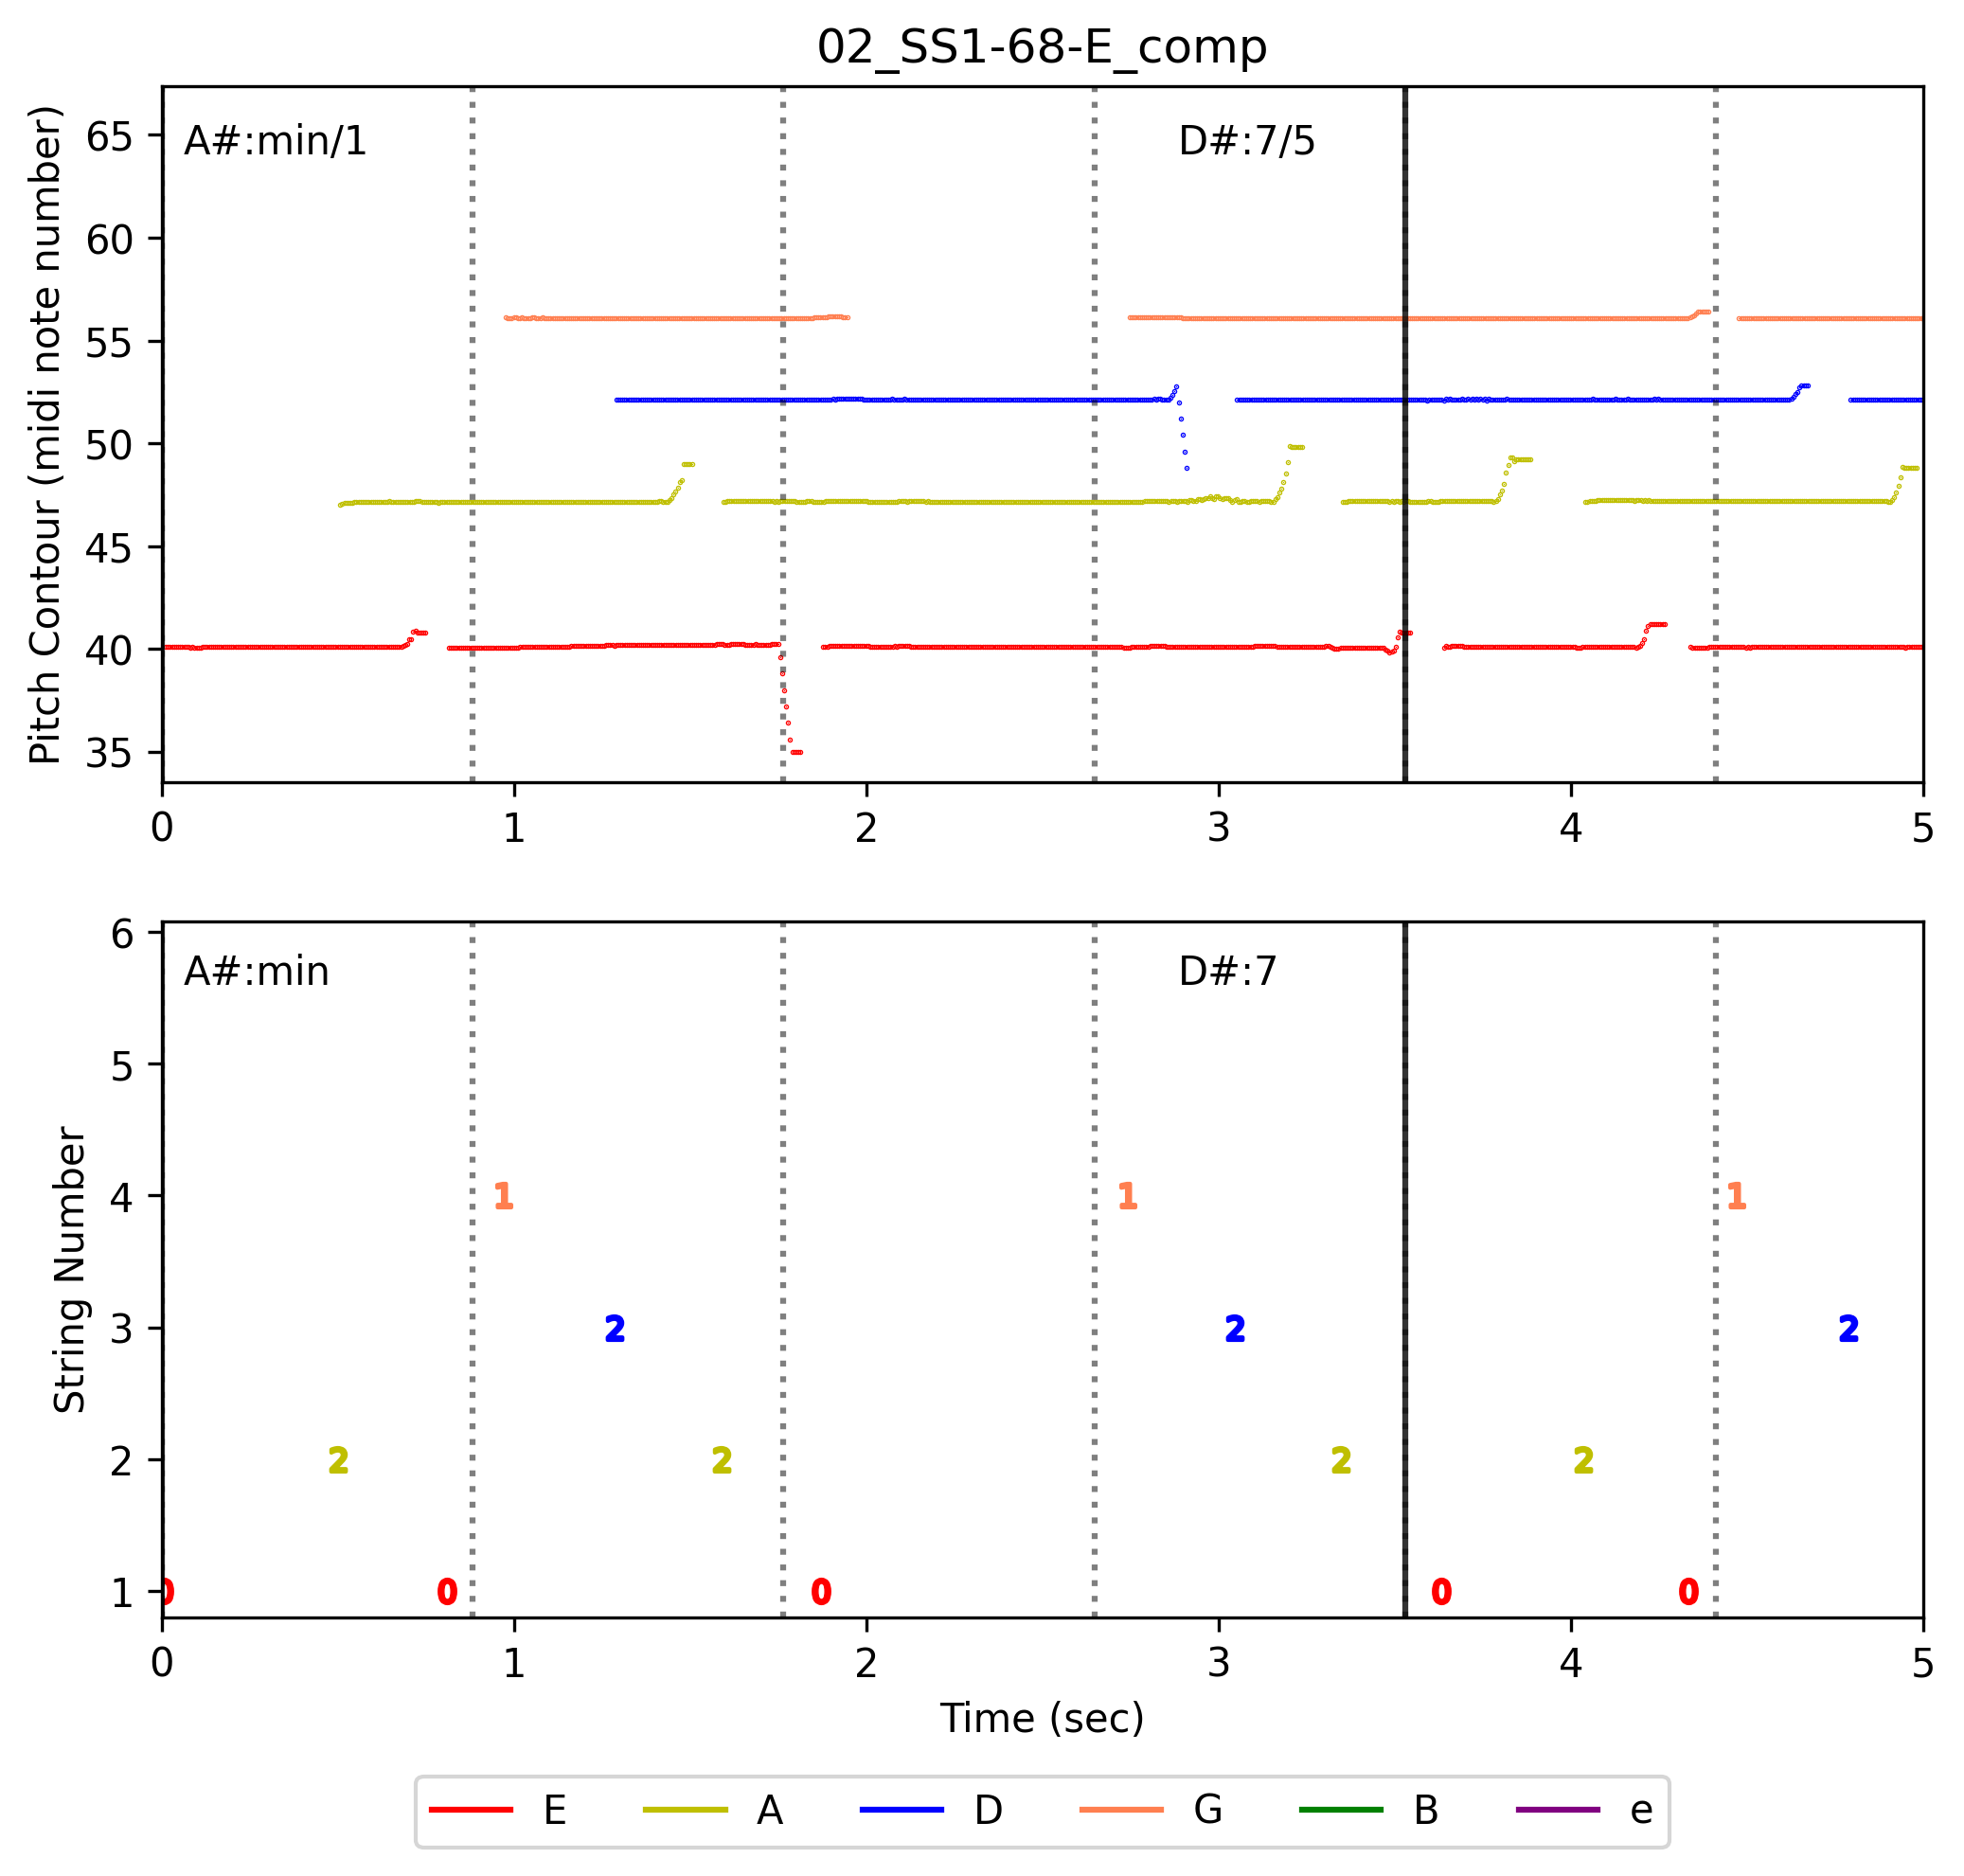

In [10]:
fig = plt.figure(figsize=(8,7), dpi=300)
ax1 = plt.subplot(211)
itp.visualize_jams_pt(jam) #pt for pitch track
ax2 = plt.subplot(212, sharex=ax1)
itp.tablaturize_jams(jam)
plt.xlim(0, 5) # this is the time window in seconds that I'm plotting

itp.add_annotations(ax1, performed_chords, ygrow_ratio=0.04, label_xoffset=0.06, label_yoffset=2)
itp.add_annotations(ax2, instructed_chords, ygrow_ratio=0.2, label_xoffset=0.06, label_yoffset=-0.4)
plt.show()


In [15]:
itp.tablaturize_jams_ascii(jam)

E |0--0---0------0--0---0------0--0---0------0--0---0-0--------------------------------0------0--0--0----0---0-0--------------------------------0--0---0--0---0--0---0--0---
A |--2---2------2--2---2--2------2---2-2------2----2------00------0--4----0-0---0--0-----2---2-2------2-----2-2---0-2-----22-2---20--0------------2--22--2---2--2---2--2---2
D |-----2------2------2-----------22-----3--------2------20---2--2--2---2--2---2-2---------2------2----2---2-----20---4-4----4--4-2-2---2---2--2----2-------2------2------2-
G |---1------1------1-------------1--------------1-----1--------------------------------------------------------------------------------------------------------------------
B |------------------------0-----------------------------------2------2------2------232----------------------------------------------2---32---------------------------------
e |------------------------------------------------------------------------------------------------------------------------------------

In [16]:
ax2

<Axes: xlabel='Time (sec)', ylabel='String Number'>